In [6]:
!conda config --add channels conda-forge
!conda install -y --update-dependencies fenics mshr matplotlib

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /srv/conda:
#
fenics                    2018.1.0         py36hba71e3e_0    conda-forge
matplotlib                2.2.2                    py36_1    conda-forge
mshr                      2018.1.0         py36h49bd758_0    conda-forge


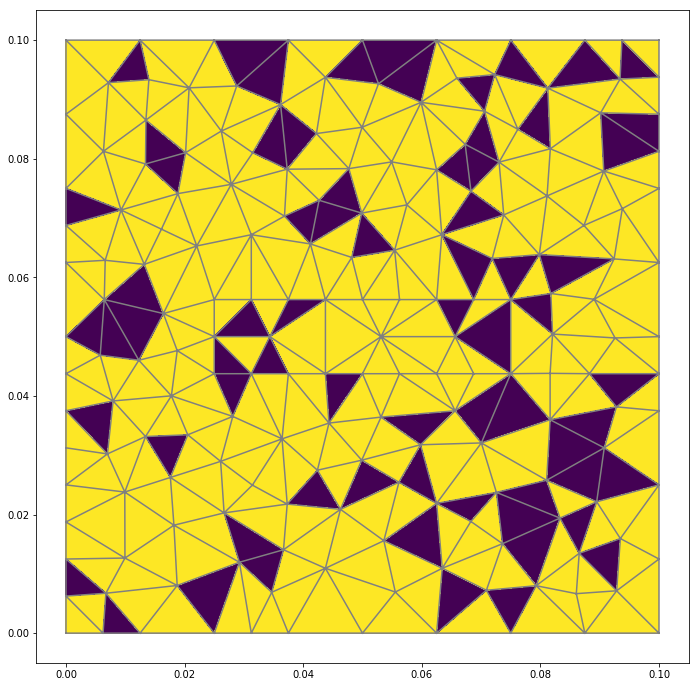

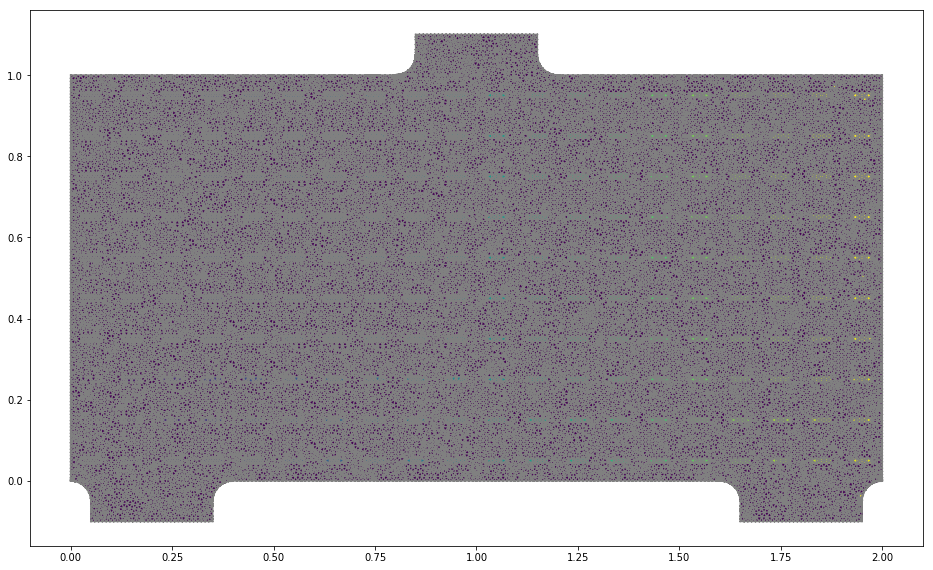

In [27]:
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt

def Fiber(w, h, x, y):
    fiber = Rectangle(Point(x - w/2, y - h/2), Point(x + w/2, y + h/2))
    return fiber

def Composite(w, h, fw, fh, dx, dy, add=None):
    domain = Rectangle(Point(0, 0), Point(w, h))
    if not add is None:
        domain += add
    nx = int(w / dx)
    ny = int(h / dy)
    for i in range(nx):
        x = w * (i + 0.5) / nx 
        for j in range(ny):
            y = h * (j + 0.5) / ny
            domain.set_subdomain(i * ny + j + 1, Fiber(fw, fh, x, y))
    return domain

def Press(w, h, rx, ry):
    press = Rectangle(Point(-w/2, -h), Point(w/2, 0)) \
          - Ellipse(Point(-w/2, -ry), rx, ry) \
          - Ellipse(Point(w/2, -ry), rx, ry) \
          - Rectangle(Point(-w/2, -h), Point(-w/2 + rx, -ry)) \
          - Rectangle(Point(w/2 - rx, -h), Point(w/2, -ry))
    return press
    
def Block(w, h, fw, fh, dx, dy, pw, ph, rx, ry):
    press = Press(pw, ph, rx, ry)
    presses = CSGTranslation(press, Point(pw/2, 0)) \
            + CSGTranslation(press, Point(w-pw/2, 0)) \
            + CSGTranslation(CSGRotation(press, DOLFIN_PI), Point(w/2, h))
    block = Composite(w, h, fw, fh, dx, dy, presses)
    return block

def SparseBlock(w, h, fw, fh, dx, dy, pw, ph, rx, ry):
    press = Press(pw, ph, rx, ry)
    presses = CSGTranslation(press, Point(pw/2, 0)) \
            + CSGTranslation(press, Point(w-pw/2, 0)) \
            + CSGTranslation(CSGRotation(press, DOLFIN_PI), Point(w/2, h))
    block = Composite(w, h, fw, fh, dx, dy, presses)
    return block    

def save(geo, name, resolution, do_plot=False):
    mesh = generate_mesh(geo, resolution)
    domains = MeshFunction("size_t", mesh, 2, mesh.domains())
    File(name + ".xml") << mesh
    File(name + "_domains.xml") << domains
    File(name + "_domains.pvd") << domains
    if do_plot:
        plt.figure(figsize=(16, 12))
        plot(mesh)
        plot(domains)
    

fiberWidth  = 0.05
fiberHeight = 0.0125
densityX    = 0.1
densityY    = 0.1
rveWidth    = 0.1
rveHeight   = 0.1
blockWidth  = 2.0
blockHeight = 1.0
pressWidth  = 0.4
pressHeight = 0.1
roundX      = 0.05
roundY      = 0.05
resolution  = 100

rve = Composite(rveWidth, rveHeight, fiberWidth, fiberHeight, densityX, densityY)
save(rve, "rve", sqrt(rveWidth*rveHeight)*resolution, True)

block = Block(blockWidth, blockHeight, fiberWidth, fiberHeight, densityX, densityX, pressWidth, pressHeight, roundX, roundY)
save(block, "block", sqrt(blockWidth*blockHeight)*resolution, True)

